In [18]:
import pandas as pd
import numpy as np
import os
import sys
import subprocess
import feather
from tqdm.notebook import tqdm
import multiprocessing as mp
import itertools
import inspect
import shutil

In [19]:
if sys.platform == 'linux':
    os.chdir('/home/chris/projects/tidal_flat_0d/')

In [49]:
def read_data(file, start, end, dt):
    def parser(x):
        return pd.datetime.strptime(x, '%d-%b-%Y %H:%M:%S')
    df = pd.read_csv(file, parse_dates=[
        'datetime'], date_parser=parser, index_col='datetime')
    df1 = df[(df.index >= start) & (df.index < end)]
    resample_df = df1.resample(dt).first()
    return resample_df['pressure'] - np.mean(resample_df['pressure'])

def rep_series(df, start, end):
    freq = df.index.freq
    index = pd.DatetimeIndex(start=start, end=rep_end, freq=freq)
    values = np.tile(df.values, rep + 1)[:len(index)]
    return pd.Series(data=values, index=index)

def make_tides(slr):
    global run_length, dt
    
    Rscript = "Rscript"
    path = os.path.join(os.getcwd(),'scripts/make_tides.R')
    subprocess.run([Rscript, path, str(run_length), str(dt), '%.4f' % slr, os.getcwd()])
    
    tides = feather.read_dataframe('./data/interim/tides/tides-yr_{0}-dt_{1}-slr_{2}.feather'.format(run_length, int(pd.to_timedelta(dt).total_seconds()/60/60), '%.4f' % slr))
    tides = tides.set_index('Datetime')
    
    return tides

def calc_c0(h, dh, z, A, timestamp):
    global ssc_by_week
    week = timestamp.week
    ssc = ssc_by_week.loc[week].values[0]
    if (h > z and dh > 0):
        return A * ssc
    else:
        return 0
    
def calc_c(c0, h, h_min_1, dh, c_min_1, z, ws, dt):
    if (h > z and dh > 0):
        return (c0 * (h-h_min_1) + c_min_1 * (h - z)) / (2 * h - h_min_1 - z + ws * dt)
    elif (h > z and dh < 0):
        return (c_min_1 * (h - z)) / (h - z + ws / dt)
    else:
        return 0
    
def calc_dz(c, ws, rho, dt):
    return (ws * c / rho) * dt


def calc_z(z_min_1, dz_min_1, dO, dP):
    return z_min_1 + dz_min_1 + dO - dP

In [50]:
def make_tide_list(slr_list):
    
    if isinstance(slr_list, list):
        pass
    elif isinstance(slr_list, float):
        slr_list = [slr_list]
        
    tides_to_make = []
    for rate in slr_list:
        file = './data/interim/tides/tides-yr_{0}-dt_{1}-slr_{2}.feather'.format(run_length, int(pd.to_timedelta(dt).total_seconds()/60/60), '%.4f' % rate)
        if not os.path.isfile(file):
            tides_to_make.append(rate)
            
    return tides_to_make

def run_model_pandas(tides, gs, rho, dP, dO, dM, A, z0, n=None):
    global ssc_by_week, num_runs
    dt = tides.index[1] - tides.index[0]
    dt_sec = dt.total_seconds()
    ws = ((gs / 1000) ** 2 * 1650 * 9.8) / 0.018
    columns = ['h', 'dh', 'C0', 'C', 'dz', 'z']
    index = tides.index
    df = pd.DataFrame(index=index, columns=columns)
    df[:] = 0
    df.loc[:, 'z'][0:2] = z0
    df.loc[:, 'h'] = tides.pressure
    df.loc[:, 'dh'] = df.loc[:, 'h'].diff() / dt_sec
    df.loc[:, 'inundated'] = 0
    df.loc[:, 'inundation_depth'] = 0

    for t in tqdm(tides.index[1:], 
                  desc='Run {0} of {1} [PID: {2}]'.format(n, num_runs, os.getpid()), 
                  total=len(tides.index[1:]), 
                  unit='steps'):
        t_min_1 = t - dt
        df.loc[t, 'z'] = calc_z(df.at[t_min_1, 'z'], df.at[t_min_1, 'dz'], 0, 0)
        df.loc[t, 'C0'] = calc_c0(df.at[t, 'h'], df.at[t, 'dh'], df.at[t, 'z'], A, t)
        df.loc[t, 'C'] = calc_c(df.at[t, 'C0'], df.at[t, 'h'], df.at[t_min_1, 'h'],
                                df.at[t, 'dh'], df.at[t_min_1, 'C'], df.at[t, 'z'], ws, dt_sec)
        df.loc[t, 'dz'] = calc_dz(df.at[t, 'C'], ws, rho, dt_sec)
        if df.at[t, 'h'] - df.at[t, 'z'] >= 0:
            df.loc[t, 'inundation_depth'] = df.at[t, 'h'] - df.at[t, 'z']
        if df.loc[t, 'C0'] != 0:
            df.loc[t, 'inundated'] = 1
        
    hours_inundated = (np.sum(df['inundated']) * dt).astype('timedelta64[h]').astype(int)
    final_elevation = df.iloc[[-1]].z.values[0]
        
    return df, hours_inundated, final_elevation

def run_model_numpy(tides, gs, rho, dP, dO, dM, A, z0, n=None):
    global ssc_by_week, num_runs
    dt = tides.index[1] - tides.index[0]
    dt_sec = dt.total_seconds()
    ws = ((gs / 1000) ** 2 * 1650 * 9.8) / 0.018
    index = tides.index
    
    z = np.zeros(len(tides.index))
    h = tides.pressure.values
    dh = np.insert(np.diff(h) / dt_sec,0,np.nan)
    inundated = np.zeros(len(tides.index))
    inundation_depth = np.zeros(len(tides.index))
    C0 = np.zeros(len(tides.index))
    C = np.zeros(len(tides.index))
    dz = np.zeros(len(tides.index))
    
    counter = np.arange(1,len(index))
    for t in tqdm(counter, 
                  desc='Run {0} of {1} [PID: {2}]'.format(n, num_runs, os.getpid()), 
                  total=len(index[1:]), 
                  unit='steps'):
        z[t] = calc_z(z[t-1], dz[t-1], 0, 0)
        C0[t] = calc_c0(h[t], dh[t], z[t], A, index[t])
        C[t] = calc_c(C0[t], h[t], h[t-1],
                                dh[t], C[t-1], z[t], ws, dt_sec)
        dz[t] = calc_dz(C[t], ws, rho, dt_sec)
        if h[t] - z[t] >= 0:
            inundation_depth[t] = h[t] - z[t]
        if C0[t] != 0:
            inundated[t] = 1
        
    hours_inundated = int(np.sum(inundated) * dt_sec / 60)
    final_elevation = z[-1]
    d = {'h' : h, 'dh' : dh, 'C0' : C0, 'C' : C, 'dz' : dz, 'z' : z, 
         'inundated' : inundated, 'inundation_depth' : inundation_depth}
    df = pd.DataFrame(data=d, index = tides.index)
    
        
    return df, hours_inundated, final_elevation

In [51]:
def make_combos(run_length, dt, slr, ssc_factor, gs, rho, dP, dO, dM, A, z0):
    args = inspect.getfullargspec(make_combos).args
    multi_args = []
    n = 0
    for arg in args:
        if isinstance(eval(arg), (list, tuple, np.ndarray)):
            multi_args.append(arg)
    single_args = list(set(args) - set(multi_args))
    dict1 = [{'{0}'.format(j) : eval(j)} for j in single_args]
    dict2 = [dict(zip(multi_args, i)) for i in itertools.product(*[eval(x) for x in multi_args])]
    for entry2 in dict2:
        for entry1 in dict1:
            entry2.update(entry1)
        entry2.update({'n' : n})
        n = n + 1

    return dict2

def parallel_parser(in_data):
    global ssc_by_week

    n = in_data['n']
    
    # make tides
    run_length = in_data['run_length']
    dt = in_data['dt']
    slr = in_data['slr']
    
    tides = feather.read_dataframe(
        './data/interim/tides/tides-yr_{0}-dt_{1}-slr_{2}.feather'.format(run_length, 
                                                                          int(pd.to_timedelta(dt).total_seconds()/60/60), 
                                                                          '%.4f' % slr))
    tides = tides.set_index('Datetime')
    
    # Load weeksly ssc
    ssc_factor = in_data['ssc_factor']
    
    ssc_file = './data/processed/ssc_by_week.csv'
    ssc_by_week = pd.read_csv(ssc_file, index_col=0) * ssc_factor
    
    # run model
    
    gs = in_data['gs']
    rho = in_data['rho']
    dP = in_data['dP']
    dO = in_data['dO']
    dM = in_data['dM']
    A = in_data['A']
    z0 = in_data['z0']
    
    run_model_numpy(tides, gs, rho, dP, dO, dM, A, z0, n=n)
    
    out_name = 'yr_{0}-slr_{1}-gs_{2}-rho_{3}-sscfactor_{4}-dP_{5}-dM_{6}-A_{7}-z0_{8}.feather'.format(run_length, slr, gs, rho, ssc_factor, dP, dM, A, z0)
    feather.write_dataframe(df.reset_index(), './data/interim/results/{0}'.format(out_name))

    return n

In [52]:
parallel = False
run_length = 50
dt = '3 hour'
slr = 0.002
ssc_factor = 1
gs = 0.035
rho = 1400
dP = 0
dO = 0
dM = 0.003
A = 0.7
z0 = 0

if parallel == True:
    poolsize = 30
    chunksize = 1
    slr = np.round(np.arange(0, 0.0325, 0.0025), 4)
    ssc_factor = np.round(np.arange(0.25, 3.25, 0.25), 2)

In [53]:
tides_to_make = make_tide_list(slr)

In [54]:
if parallel == True:
    
    model_runs = make_combos(run_length, dt, slr, ssc_factor, gs, rho, dP, dO, dM, A, z0)
    num_runs = len(model_runs)
            
    if len(tides_to_make) == 0:
        print('All tidal curves already constructed!')
    else:
        print('Making {0} tidal curves.'.format(len(tides_to_make)))
        with mp.Pool(poolsize) as pool:
            for new_tide in tqdm(pool.imap_unordered(make_tides, tides_to_make),
                      total=len(tides_to_make), 
                      unit='tidal curves'):
                pass
    
    with mp.Pool(poolsize) as pool:
        for result in pool.imap_unordered(parallel_parser, model_runs, chunksize=chunksize):
            pass
        
else:
    tides = make_tides(slr)
    ssc_file = './data/processed/ssc_by_week.csv'
    ssc_by_week = pd.read_csv(ssc_file, index_col=0) * ssc_factor
    num_runs = 1

    df, hours_inundated, final_elevation = run_model_numpy(tides, gs, rho, dP, dO, dM, A, z0, n=1)
    out_name = 'yr_{0}-slr_{1}-gs_{2}-rho_{3}-sscfactor_{4}-dP_{5}-dM_{6}-A_{7}-z0_{8}.feather'.format(run_length, slr, gs, rho, ssc_factor, dP, dM, A, z0)
    feather.write_dataframe(df.reset_index(), './data/interim/results/{0}'.format(out_name))

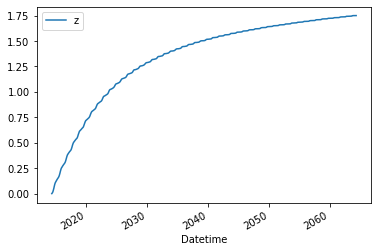

In [55]:
df.plot(y='z')

In [63]:
df.z[df.index > '2015-05-17']

Datetime
2015-05-17 01:20:00+06:00    0.150695
2015-05-17 04:20:00+06:00    0.150704
2015-05-17 07:20:00+06:00    0.150704
2015-05-17 10:20:00+06:00    0.150704
2015-05-17 13:20:00+06:00    0.150811
                               ...   
2064-05-17 10:20:00+06:00    1.750150
2064-05-17 13:20:00+06:00    1.750150
2064-05-17 16:20:00+06:00    1.750150
2064-05-17 19:20:00+06:00    1.750150
2064-05-17 22:20:00+06:00    1.750150
Name: z, Length: 143192, dtype: float64